In [1]:
import sys
import os
import pandas as pd

# Add the project root to sys.path so Python can find src
PROJECT_ROOT = os.path.abspath("..")  # notebooks/.. → imdb-sentiment/
sys.path.append(PROJECT_ROOT)

# Now import your module
from src.data import load_imdb

# Paths to your data
train_path = os.path.join(PROJECT_ROOT, "data", "raw", "aclImdb", "train")
test_path = os.path.join(PROJECT_ROOT, "data", "raw", "aclImdb", "test")

# Load the dataset
train_df = load_imdb(train_path)
test_df = load_imdb(test_path)

# Check
print(train_df.head())
print(test_df.head())
print(train_df.shape)




                                                text  label
0  Bromwell High is a cartoon comedy. It ran at t...      1
1  Homelessness (or Houselessness as George Carli...      1
2  Brilliant over-acting by Lesley Ann Warren. Be...      1
3  This is easily the most underrated film inn th...      1
4  This is not the typical Mel Brooks film. It wa...      1
                                                text  label
0  I went and saw this movie last night after bei...      1
1  Actor turned director Bill Paxton follows up h...      1
2  As a recreational golfer with some knowledge o...      1
3  I saw this film in a sneak preview, and it is ...      1
4  Bill Paxton has taken the true story of the 19...      1
(25000, 2)


In [2]:
train_df.to_csv('../data/processed/train_raw.csv', index=False)
test_df.to_csv('../data/processed/test_raw.csv', index=False)


In [3]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

STOPWORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)

    # 3. Remove non-alphabetic characters (punctuation, numbers)
    text = re.sub(r"[^a-z\s]", " ", text)

    # 4. Tokenize
    tokens = word_tokenize(text)

    # 5. Remove stopwords
    tokens = [t for t in tokens if t not in STOPWORDS]

    # 6. Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)


In [5]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\venka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)

In [7]:
train_df.to_csv("../data/processed/train_clean.csv", index=False)
test_df.to_csv("../data/processed/test_clean.csv", index=False)


In [8]:
train_df[["text", "clean_text"]].head(10)


,text,clean_text
0,Bromwell High is a cartoon comedy. It ran at t...,bromwell high cartoon comedy ran time program ...
1,Homelessness (or Houselessness as George Carli...,homelessness houselessness george carlin state...
2,Brilliant over-acting by Lesley Ann Warren. Be...,brilliant acting lesley ann warren best dramat...
3,This is easily the most underrated film inn th...,easily underrated film inn brook cannon sure f...
4,This is not the typical Mel Brooks film. It wa...,typical mel brook film much less slapstick mov...
5,"This isn't the comedic Robin Williams, nor is ...",comedic robin williams quirky insane robin wil...
6,Yes its an art... to successfully make a slow ...,yes art successfully make slow paced thriller ...
7,"In this ""critically acclaimed psychological th...",critically acclaimed psychological thriller ba...
8,THE NIGHT LISTENER (2006) **1/2 Robin Williams...,night listener robin williams toni collette bo...
9,"You know, Robin Williams, God bless him, is co...",know robin williams god bless constantly shoot...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1,3), max_features=20000, binary=True)


X_train_counts = vect.fit_transform(train_df['clean_text'])


X_test_counts = vect.transform(test_df['clean_text'])

print("train shape:", X_train_counts.shape)
print("test shape:", X_test_counts.shape)
print("dtype:", X_train_counts.dtype, "sparsity:", X_train_counts.nnz / (X_train_counts.shape[0]*X_train_counts.shape[1]))


train shape: (25000, 20000)
test shape: (25000, 20000)
dtype: int64 sparsity: 0.005344216


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Build pipeline: vectorizer then classifier
pipeline_nb = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,3), max_features=20000, binary=True)),
    ('clf', MultinomialNB(alpha=1.0))
])

# Fit on train (vectorizer will be fit inside pipeline)
pipeline_nb.fit(train_df['clean_text'], train_df['label'])

# Predict on test
y_pred = pipeline_nb.predict(test_df['clean_text'])

# Evaluate
print(classification_report(test_df['label'], y_pred))
cm = confusion_matrix(test_df['label'], y_pred)
print("Confusion matrix:\n", cm)


              precision    recall  f1-score   support

           0       0.86      0.87      0.86     12500
           1       0.87      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

Confusion matrix:
 [[10863  1637]
 [ 1821 10679]]


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=20000)   # try unigrams+bigrams
X_train_tfidf = tfidf.fit_transform(train_df['clean_text'])
X_test_tfidf  = tfidf.transform(test_df['clean_text'])

print("TFIDF train shape:", X_train_tfidf.shape)
print("TFIDF test shape:", X_test_tfidf.shape)


TFIDF train shape: (25000, 20000)
TFIDF test shape: (25000, 20000)


In [12]:
from sklearn.linear_model import LogisticRegression

pipeline_lr = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,2), max_features=20000)),
    ('clf', LogisticRegression(solver='saga', max_iter=1000))
])

pipeline_lr.fit(train_df['clean_text'], train_df['label'])
print(classification_report(test_df['label'], pipeline_lr.predict(test_df['clean_text'])))


              precision    recall  f1-score   support

           0       0.89      0.88      0.89     12500
           1       0.88      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



In [13]:
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='saga', max_iter=1000))
])

param_grid = {
    'vect__ngram_range': [(1,1), (1,2)],
    'vect__max_features': [5000, 20000],
    'clf__C': [0.1, 1.0]
}

gs = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, verbose=2)
gs.fit(train_df['clean_text'], train_df['label'])

print("Best params:", gs.best_params_)
print("Test report:")
print(classification_report(test_df['label'], gs.predict(test_df['clean_text'])))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params: {'clf__C': 1.0, 'vect__max_features': 5000, 'vect__ngram_range': (1, 2)}
Test report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     12500
           1       0.88      0.89      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [14]:
import joblib
joblib.dump(pipeline_nb, "../models/nb_pipeline.joblib")
# or save a GridSearch best estimator:
# joblib.dump(gs.best_estimator_, "../models/best_lr_pipeline.joblib")


['../models/nb_pipeline.joblib']

In [15]:
import joblib

# save pipeline
joblib.dump(pipeline_lr, "../models/logreg_tfidf_pipeline.joblib")
print("Model saved!")


Model saved!


In [16]:
# load pipeline back
loaded_model = joblib.load("../models/logreg_tfidf_pipeline.joblib")

# test on one review
sample = "The movie was absolutely wonderful, I loved it!"
print("Prediction:", loaded_model.predict([sample])[0])


Prediction: 1


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# pipeline for SVM
pipeline_svm = Pipeline([
    ("vect", TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ("clf", LinearSVC(C=1.0))  # C = inverse of regularization strength
])

pipeline_svm.fit(train_df["clean_text"], train_df["label"])
y_pred = pipeline_svm.predict(test_df["clean_text"])

print("SVM Classification Report:")
print(classification_report(test_df["label"], y_pred))

print("Confusion Matrix:")
print(confusion_matrix(test_df["label"], y_pred))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     12500
           1       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

Confusion Matrix:
[[11043  1457]
 [ 1716 10784]]


In [18]:
import joblib

joblib.dump(pipeline_svm, "../models/svm_tfidf_pipeline.joblib")
print("SVM pipeline saved!")


SVM pipeline saved!


In [19]:
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
    ("vect", TfidfVectorizer(max_features=10000, ngram_range=(1,3))),  # smaller features for speed
    ("clf", RandomForestClassifier(n_estimators=100, max_depth=50, random_state=42, n_jobs=-1))
])

pipeline_rf.fit(train_df["clean_text"], train_df["label"])
y_pred = pipeline_rf.predict(test_df["clean_text"])

print("Random Forest Classification Report:")
print(classification_report(test_df["label"], y_pred))

print("Confusion Matrix:")
print(confusion_matrix(test_df["label"], y_pred))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85     12500
           1       0.84      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Confusion Matrix:
[[10521  1979]
 [ 1810 10690]]


In [20]:
import joblib

joblib.dump(pipeline_rf, "../models/rf_tfidf_pipeline.joblib")
print("Random Forest pipeline saved!")


Random Forest pipeline saved!


In [21]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline_gb = Pipeline([
    ("vect", TfidfVectorizer(max_features=10000, ngram_range=(1,2))),  # smaller vocab for speed
    ("clf", GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
])

pipeline_gb.fit(train_df["clean_text"], train_df["label"])
y_pred = pipeline_gb.predict(test_df["clean_text"])

print("Gradient Boosting Classification Report:")
print(classification_report(test_df["label"], y_pred))

print("Confusion Matrix:")
print(confusion_matrix(test_df["label"], y_pred))


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80     12500
           1       0.78      0.86      0.82     12500

    accuracy                           0.81     25000
   macro avg       0.82      0.81      0.81     25000
weighted avg       0.82      0.81      0.81     25000

Confusion Matrix:
[[ 9477  3023]
 [ 1688 10812]]


In [22]:
import joblib
joblib.dump(pipeline_gb, "../models/gb_tfidf_pipeline.joblib")
print("Gradient Boosting pipeline saved!")


Gradient Boosting pipeline saved!


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,3))
X_train_tfidf = tfidf.fit_transform(train_df["clean_text"])
X_test_tfidf  = tfidf.transform(test_df["clean_text"])

y_train = train_df["label"].values
y_test  = test_df["label"].values

# Convert to dense arrays
X_train_dense = X_train_tfidf.toarray()
X_test_dense  = X_test_tfidf.toarray()

print("Train shape:", X_train_dense.shape, " Test shape:", X_test_dense.shape)


Train shape: (25000, 10000)  Test shape: (25000, 10000)


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Simple feedforward NN
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary output
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


c:\Users\venka\Uday\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │       1,280,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,288,449 (4.92 MB)

 Trainable params: 1,288,449 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(
    X_train_dense, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=128,
    verbose=2
)


Epoch 1/5
157/157 - 8s - 53ms/step - accuracy: 0.7841 - loss: 0.4405 - val_accuracy: 0.7966 - val_loss: 0.4958
Epoch 2/5
157/157 - 4s - 26ms/step - accuracy: 0.9252 - loss: 0.2006 - val_accuracy: 0.8298 - val_loss: 0.4308
Epoch 3/5
157/157 - 4s - 25ms/step - accuracy: 0.9561 - loss: 0.1263 - val_accuracy: 0.8096 - val_loss: 0.5592
Epoch 4/5
157/157 - 4s - 23ms/step - accuracy: 0.9731 - loss: 0.0829 - val_accuracy: 0.8228 - val_loss: 0.5917
Epoch 5/5
157/157 - 4s - 25ms/step - accuracy: 0.9865 - loss: 0.0488 - val_accuracy: 0.8354 - val_loss: 0.6289


In [27]:
loss, acc = model.evaluate(X_test_dense, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")


Test Accuracy: 0.8564


In [28]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred_probs = model.predict(X_test_dense)
y_pred = (y_pred_probs > 0.5).astype("int32")

print("DNN Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
DNN Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     12500
           1       0.84      0.88      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

Confusion Matrix:
[[10457  2043]
 [ 1546 10954]]


In [29]:
import pandas as pd

results = []

# Add your results manually from reports you already got
results.append({"Model": "Naive Bayes", "Accuracy": 0.86})
results.append({"Model": "Logistic Regression", "Accuracy": 0.89})
results.append({"Model": "SVM", "Accuracy": 0.87})
results.append({"Model": "Random Forest", "Accuracy": 0.85})
results.append({"Model": "Gradient Boosting", "Accuracy": 0.81})
results.append({"Model": "Deep Neural Network", "Accuracy": 0.86})

df_results = pd.DataFrame(results)
print(df_results)


                 Model  Accuracy
0          Naive Bayes      0.86
1  Logistic Regression      0.89
2                  SVM      0.87
3        Random Forest      0.85
4    Gradient Boosting      0.81
5  Deep Neural Network      0.86


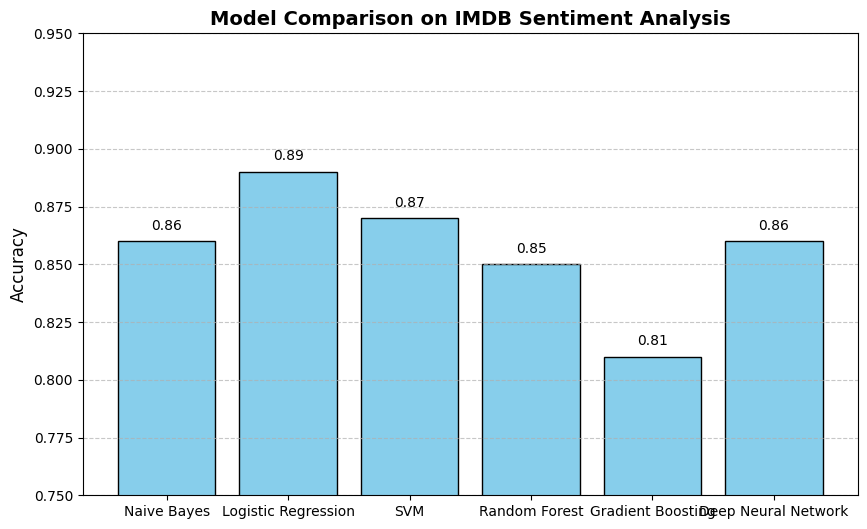

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(df_results["Model"], df_results["Accuracy"], color="skyblue", edgecolor="black")
plt.title("Model Comparison on IMDB Sentiment Analysis", fontsize=14, weight="bold")
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0.75, 0.95)  # focus range for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add values above bars
for i, acc in enumerate(df_results["Accuracy"]):
    plt.text(i, acc + 0.005, f"{acc:.2f}", ha="center", fontsize=10)

plt.show()
